In [1]:
import sys
import os
os.environ['PROJ_DATA'] = "/pscratch/sd/p/plutzner/proj_data"
import xarray as xr
import torch
import torchinfo
import random
import numpy as np
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import json
import pickle
import gzip
import scipy
from scipy import stats
#import matplotlib.colors as mcolorsxx

%load_ext autoreload
%autoreload 2
import utils
import utils.filemethods as filemethods
import databuilder.data_loader as data_loader
import databuilder.data_generator as data_generator
from databuilder.data_generator import ClimateData
import model.loss as module_loss
import model.metric as module_metric
from databuilder.data_generator import multi_input_data_organizer
import databuilder.data_loader as data_loader
from trainer.trainer import Trainer
from model.build_model import TorchModel
from base.base_model import BaseModel
from utils import utils
from shash.shash_torch import Shash

In [2]:
config = utils.get_config("exp006")
seed = config["seed_list"][0]

In [3]:
# Setup the Data
front_cutoff = config["databuilder"]["front_cutoff"] # remove front nans : 74 ENSO - two front nans before daily interpolation = 60 days, daily interpolation takes 1/2 the original time step = 15 days TOTAL = ~75
back_cutoff = config["databuilder"]["back_cutoff"]  # remove back nans 

trainset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_train.pkl", front_cutoff, back_cutoff)
valset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_val.pkl", front_cutoff, back_cutoff)
testset = data_loader.CustomData(config["data_loader"]["data_dir"] + "/Network Inputs/exp006_test.pkl", front_cutoff, back_cutoff)


X1 shape: (60058, 3)
Target shape: (60058,)
X1 shape: (60058, 3)
Target shape: (60058,)
X1 shape: (60058, 3)
Target shape: (60058,)


In [77]:
# Prepare Model and Target Data

# Open Model Outputs
model_output_pred = '/Users/C830793391/Documents/Research/E3SM/saved/output/exp006_output_pred_testset.pkl'
with gzip.open(model_output_pred, "rb") as obj1:
    output = pickle.load(obj1)

# Open Target Data (test set)
target_file = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test.pkl'
with gzip.open(target_file, "rb") as obj1:
    test_target = pickle.load(obj1)

test_target = test_target["y"][front_cutoff : -back_cutoff]

# SHORTEN SAMPLES FOR SPEED: 
# output = output[30000:40000, :]
# test_target = test_target[30000:40000]

In [92]:
def _discover_bounds(pdf):
    upper = pdf.max()
    lower = pdf.min()
    return lower, upper

def cdf_callable(p, x):    

    cdf = np.zeros([len(x), len(output[:,0])])
    for isamp, samp in enumerate(output):
        pdf = p[:,isamp] / np.sum(p[:,isamp])
        cdf[:, isamp] = np.cumsum(pdf)
    return cdf
    

In [75]:
def _crps_cdf_single(x, cdf_or_dist, xmin=None, xmax=None, tol=1e-6):
    """
    See crps_cdf for docs.
    """
    # TODO: this function is pretty slow.  Look for clever ways to speed it up.

    # allow for directly passing in scipy.stats distribution objects.
    cdf = getattr(cdf_or_dist, 'cdf', cdf_or_dist)
    assert callable(cdf)

    # if bounds aren't given, discover them
    if xmin is None or xmax is None:
        # Note that infinite values for xmin and xmax are valid, but
        # it slows down the resulting quadrature significantly.
        xmin, xmax = _discover_bounds(cdf)

    # make sure the bounds haven't clipped the cdf.
    if (tol is not None) and (cdf(xmin) >= tol) or (cdf(xmax) <= (1. - tol)):
        raise ValueError('CDF does not meet tolerance requirements at %s '
                         'extreme(s)! Consider using function defaults '
                         'or using infinities at the bounds. '
                         % ('lower' if cdf(xmin) >= tol else 'upper'))
    
  # CRPS = int_-inf^inf (F(y) - H(x))**2 dy
    #      = int_-inf^x F(y)**2 dy + int_x^inf (1 - F(y))**2 dy
    def lhs(y):
        # left hand side of CRPS integral
        return np.square(cdf(y))
    # use quadrature to integrate the lhs
    lhs_int, lhs_tol = scipy.integrate.quad(lhs, xmin, x)
    # make sure the resulting CRPS will be with tolerance
    if (tol is not None) and (lhs_tol >= 0.5 * tol):
        raise ValueError('Lower integral did not evaluate to within tolerance! '
                         'Tolerance achieved: %f , Value of integral: %f \n'
                         'Consider setting the lower bound to -np.inf.' %
                         (lhs_tol, lhs_int))

    def rhs(y):
        # right hand side of CRPS integral
        return np.square(1. - cdf(y))
    rhs_int, rhs_tol = scipy.integrate.quad(rhs, x, xmax)
    # make sure the resulting CRPS will be with tolerance
    if (tol is not None) and (rhs_tol >= 0.5 * tol):
        raise ValueError('Upper integral did not evaluate to within tolerance! \n'
                         'Tolerance achieved: %f , Value of integral: %f \n'
                         'Consider setting the upper bound to np.inf or if '
                         'you already have, set warn_level to `ignore`.' %
                         (rhs_tol, rhs_int))

    return lhs_int + rhs_int

_crps_cdf = np.vectorize(_crps_cdf_single)

In [74]:
def crps_quadrature(x, cdf_or_dist, xmin=None, xmax=None, tol=1e-6):
    """
    Compute the continuously ranked probability score (CPRS) for a given
    forecast distribution (cdf) and observation (x) using numerical quadrature.

    This implementation allows the computation of CRPS for arbitrary forecast
    distributions. If gaussianity can be assumed ``crps_gaussian`` is faster.

    Parameters
    ----------
    x : np.ndarray
        Observations associated with the forecast distribution cdf_or_dist
    cdf_or_dist : callable or scipy.stats.distribution
        Function which returns the the cumulative density of the
        forecast distribution at value x.  This can also be an object with
        a callable cdf() method such as a scipy.stats.distribution object.
    xmin : np.ndarray or scalar
        The lower bounds for integration, this is required to perform
        quadrature.
    xmax : np.ndarray or scalar
        The upper bounds for integration, this is required to perform
        quadrature.
    tol : float , optional
        The desired accuracy of the CRPS, larger values will speed
        up integration. If tol is set to None, bounds errors or integration
        tolerance errors will be ignored.

    Returns
    -------
    crps : np.ndarray
        The continuously ranked probability score of an observation x
        given forecast distribution.
    """
    return _crps_cdf(x, cdf_or_dist, xmin, xmax, tol)

In [98]:
#PROPER SCORING CODE IMPLEMENTATION:

x = np.arange(-12, 12, 0.01)
dist = Shash(output)
p = dist.prob(x).numpy()
print(p.shape)

cdf = cdf_callable(p = p, x = x)
lb, ub = _discover_bounds(p)
# assert callable(cdf_callable(p=p, x=x))
print(callable(cdf))
crps_cdf = np.zeros([len(output[:,0]), 2]) 


crps_cdf[isample, 0] = crps_quadrature(sample, cdf_callable, xmin = lowerbound, xmax = upperbound, tol=1e-5)
crps_cdf[isample, 1] = isample

(2400, 60058)
False


TypeError: cdf_callable() missing 1 required positional argument: 'x'

In [ ]:
plt.figure()
plt.plot(cdf)

In [ ]:
print(test_target[samples])
print(crps_cdf[samples])

In [ ]:
# CRPS variation with target Value = Minimum CRPS around -1mm/day
plt.figure()
plt.scatter(test_target, CRPS, s = 0.5)
plt.xlabel("Target Value")
plt.ylabel("CRPS")
# plt.xlim([-.1, .15])
# plt.ylim([-.005,.1])

In [ ]:
# Accuracy VS Confidence Plot

plt.figure()
plt.scatter(output[:,2], CRPS , s = 0.8, color = 'teal') # CRPS (accuracy) vs. Standard Deviation (confidence)
plt.ylabel("CRPS")
plt.xlabel(r"Gamma of SHASH ($\gamma$)")

In [ ]:
# Confidence vs Target Value

plt.figure()
plt.scatter(test_target, output[:,2] , s = 0.8, color = 'purple') # CRPS (accuracy) vs. Standard Deviation (confidence)
plt.xlabel("Target")
plt.ylabel(r"Gamma of SHASH ($\gamma$)" "\n" "(Confidence)")

0.17974531649174405
Total area under the histogram: 1.0


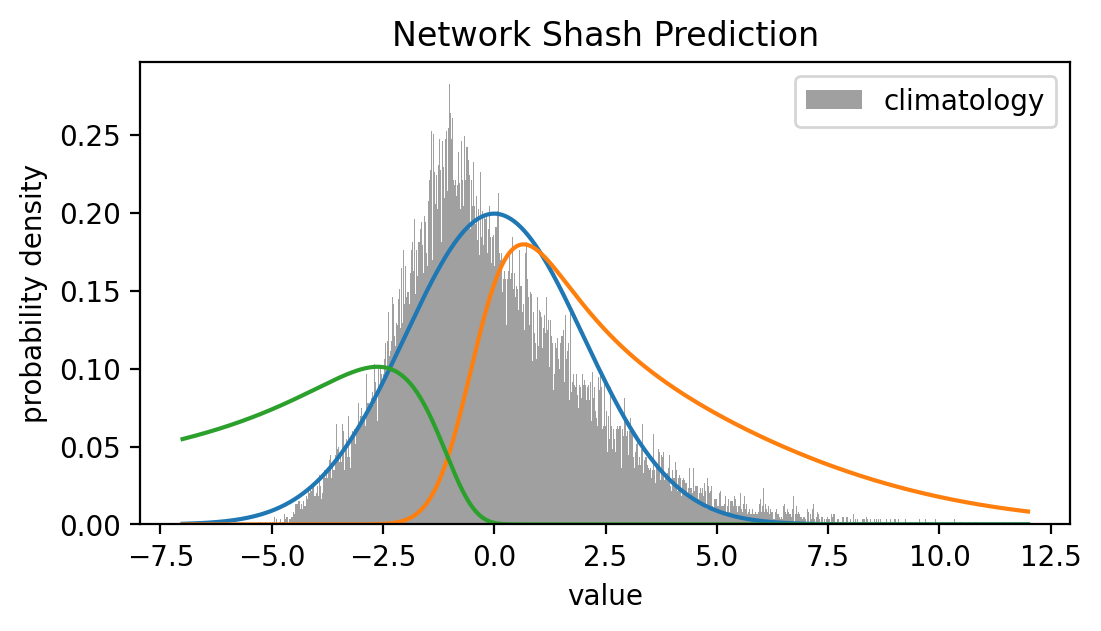

In [34]:
import shash.shash_torch
from shash.shash_torch import Shash
imp.reload(shash.shash_torch)

output_test = np.array([[0   , 2   , 0.0001,           1. ], 
                  [0    , 2   , 1   ,           1.], 
                  [0    , 2   , -2  ,     1. ]])

climate_data = '/Users/C830793391/BIG_DATA/E3SM_Data/presaved/Network Inputs/exp006_test.pkl'

with gzip.open(climate_data, "rb") as obj1:
    data = pickle.load(obj1)
climatology = data["y"]

# bins_inc = 0.025
# bins = np.arange(-10, 10, bins_inc)

plt.figure(figsize=(6, 3), dpi=200)

x = np.arange(-7, 12, 0.01)
dist = Shash(output)
p = dist.prob(x).numpy()

print(np.max(p[:,1]))

counts, bin_edges, __ = plt.hist(
    climatology, x, density=True, color="gray", alpha=0.75, label="climatology"
)
bin_widths = np.diff(bin_edges)
area = np.sum(counts * bin_widths)
print(f'Total area under the histogram: {area}')

plt.plot(x, p)
plt.xlabel("value")
plt.ylabel("probability density")
plt.title("Network Shash Prediction")
plt.legend()
plt.show()

(1900,)


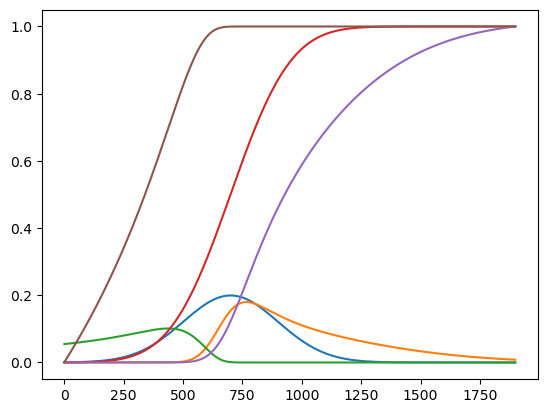

In [62]:
p_dist_test = Shash(output_test)
p_dist_test = p_dist_test.prob(x).numpy()
plt.plot(p_dist_test)

pdf_test1 = p_dist_test[:,0] / np.sum(p_dist_test[:,0])
pdf_test2 = p_dist_test[:,1] / np.sum(p_dist_test[:,1])
pdf_test3 = p_dist_test[:,2] / np.sum(p_dist_test[:,2])
cdf_test1 = np.cumsum(pdf_test1)
cdf_test2 = np.cumsum(pdf_test2)
cdf_test3 = np.cumsum(pdf_test3)
plt.plot(cdf_test1)
plt.plot(cdf_test2)
plt.plot(cdf_test3)
print(cdf_test1.shape)


In [64]:
test_test = [1, 4, -5]

In [71]:
cdf_dist_shash = Shash(output_test)
cdf_dist_test = cdf_dist_shash.prob(x).numpy()